<a href="https://colab.research.google.com/github/ucfilho/Raianars_Thesis/blob/main/Ensaio_06_DE_OPTIM_ANN_v_02_B_stat_mod_Insight_DIVERSIDADE_3x4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
############################### Importar códigos
!git clone https://github.com/ucfilho/optim_raianars_Insight/ #clonar do Github
%cd optim_raianars_Insight
import de_soma_Insight
import de_bounds_matriz
import Go2Ann

fatal: destination path 'optim_raianars_Insight' already exists and is not an empty directory.
/content/optim_raianars_Insight/Raianars_paper_One/ANN_read_matrix/optim_raianars_Insight


In [28]:
!git clone https://github.com/ucfilho/Raianars_paper_One #clonar do Github
%cd Raianars_paper_One

fatal: destination path 'Raianars_paper_One' already exists and is not an empty directory.
/content/optim_raianars_Insight/Raianars_paper_One/ANN_read_matrix/optim_raianars_Insight/Raianars_paper_One


In [29]:
#import Go2Ann
#import de_soma_Insight
#import de_bounds_matriz
#import Function
#import Go2MinMax
from AvaliaX import AvaliaX
#from Function import FUN
#from Function import Function.FUN
#from Function import Function.Fun
#from Function import Function
from GeraIndices import GeraIndices
import numpy as np
import time
import matplotlib.pyplot as plt
from random import randint
from scipy import optimize
import pandas as pd
from sklearn.metrics import confusion_matrix

############################### DADOS DE ENTRADA 
RUNS=50 #NÚMERO DE RODADAS
Fc=0.1 # fator de correcao parametros da ANN
its=1 #10 # quantas vezes vai usar o NPAR antes de alterar de novo
ITE=300 #10 # PONTOS quantas vezes vai alteral NPAR 
NPAR=150
mut=0.5
crossp=0.5
Fi=mut;CRi=crossp;# para impressão
fator = 1.0/2.0; 

# Fun=Function.FUN
# Fun=FUN
############################### Função
#dim=12

MAX=np.array([3,3,3,3,1,1,1,1,0,0,0,0])
MIN=np.array([2,2,2,2,0,0,0,0,-100,-100,-100,-100])
#MAX=np.array([3,3,3,3,3,3,3,3,0,0,0,0])
#MIN=np.array([0,0,0,0,0,0,0,0,-100,-100,-100,-100])

bounds=[]
for k in range(len(MAX)):
  bounds.append((MIN[k],MAX[k]))

In [30]:
#********************PROGRAMA PRINCIPAL*************************

Trocas=4
mCp=[4,2,1.5,3] #[kW/K]
tempInicial=[453.0,393.0,523.0,533.0] #[K]
tempAtual=np.copy(tempInicial) 
#tempAtual=[453,393,523,533] #[K]
tempAlvo=[513.0,508.0,403.0,433.0] #[K]
U=0.2 #[kW/(m2.K)]
coefCustoUQ=110 #[$/(kW.ano)]
coefCustoUF=12.2 #[$/(kW.ano)]

In [31]:
def Area(x):

  global mCp,tempAlvo,tempInicial,Trocas,U
  
  NPAR=1
  
  Area=[]

  Ind_I,Ind_J,deltaT,Tin, Tout=buildMatriz(x) 
  Tatual=np.copy(np.array(tempInicial))

  rows=Trocas 
  cols=len(mCp)

  Area_Particula=[]

  for k in range(Trocas):

    i=Ind_I[0,k]
    j=Ind_J[0,k]
    tempSaidaQ=Tatual[i]+deltaT[0,k]
    tempSaidaF=-deltaT[0,k]*mCp[i]/(mCp[j])+Tatual[j]

    Told_i=Tatual[i]
    Told_j=Tatual[j]

    Tatual[i]=np.copy(tempSaidaQ)
    Tatual[j]=np.copy(tempSaidaF)
    deltaT1=Tatual[i]-tempSaidaF
    deltaT2=tempSaidaQ-Tatual[j]
    try:
      A=(deltaT1-deltaT2)
      B=np.log((deltaT1/deltaT2))
      deltaTMediaLog=A/B
    except:
      deltaTMediaLog=1e99
  
    if(deltaTMediaLog==1e99):
      AreaCalc=1e99
    else:
      AreaCalc=abs(deltaT[0,k]*mCp[i]/(U*deltaTMediaLog))

    if(Told_i==Tatual[i]):
      AreaCalc=0

    if(Told_j==Tatual[j]):
      AreaCalc=0

      Area_Particula.append(AreaCalc)
      
  Area.append(Area_Particula)

  return Area

def buildMatriz(x):
  global Trocas, tempInicial, tempAtual 
  NPAR=1
  cols=len(tempInicial)
  size=3*cols
  x=np.array(x).reshape(1,size)
  # print('x=');print(x)
  Ind_I=np.zeros((NPAR,Trocas)).astype(np.int64)
  Ind_J=np.zeros((NPAR,Trocas)).astype(np.int64)
  Tin=np.zeros((NPAR,Trocas))
  Tout=np.zeros((NPAR,Trocas))
  deltaT=np.zeros((NPAR,Trocas))
  for i in range(NPAR):
    for j in range(Trocas):
      #print('[i,j]=%d %d'%(i,j))
      Ind_I[i,j]=round(x[i,j])
      Ind_J[i,j]=round(x[i,j+Trocas])
      deltaT[i,j]=x[i,j+2*Trocas] 
    for jj in range(cols):
      Tin[i,jj]=tempInicial[jj]
      Tout[i,jj]=tempAtual[jj]
  return Ind_I,Ind_J,deltaT, Tin, Tout

def CustoProcesso(Area,Utilidades,cargaUFtodas,cargaUQtodas):
  global coefCustoUQ,coefCustoUF
  
  NPAR=1

  cost=np.zeros((NPAR))
  for i in range(NPAR):
    cargaUQ=cargaUQtodas[i]
    cargaUF=cargaUFtodas[i]
    areaTrocadores=Area[i]
    areaUtilidades=Utilidades[i]
    costTrocadores=0
    for it in areaTrocadores:
      for wii in areaUtilidades:
        if(it<1e99):
          if(wii<1e99):
            costTrocadores=costTrocadores+300*(it**0.5+wii**0.5)
          else:
            costTrocadores=1e99
            break
    costUQ=coefCustoUQ*cargaUQ
    costUF=coefCustoUF*cargaUF
    
    if(costTrocadores==1e99):
      cost[i]=1e99
    else:
      cost[i]=costUQ+costUF+costTrocadores
      
  return cost

def Temperatura(x):
  global Trocas, mCp,tempInicial
  
  NPAR=1
  Ind_I,Ind_J,deltaT,Tin, Tout=buildMatriz(x) 
  Tatual=np.copy(np.array(tempInicial))

  erro=np.zeros((NPAR)) # valor erro se torna erro=1 quando ha algum erro e vai penalizar
  for ki in range(NPAR):
    for kj in range(Trocas):
      #Tin=np.copy(Tout)
      k=kj
      i=Ind_I[ki,kj]
      j=Ind_J[ki,kj]
      
      tempSaidaQ=Tout[ki,i]+deltaT[ki,kj]
      tempSaidaF=-mCp[kj]*deltaT[ki,kj]/(mCp[j])+Tout[ki,j]
      flag=0 # flag : indica que nao entra no teste logico
      # usei flag no lugar q ifs pq a identacao ficou melhor assim
      if(Tout[ki,i] > Tout[ki,j]): #Tquente maior Tfria: vaores atuais
        if(tempSaidaQ > tempSaidaF): #Tquente maior Tfria: saidas
          flag=1
      if(flag>0):
        Tout[ki,i]=tempSaidaQ
        Tout[ki,j]=tempSaidaF
      else:
        erro[ki]=1

  return Tout,erro

def Utilidades(tempAlvo,Tout,mCp):

  cols=len(mCp)
  NPAR=1

  
  '''
  caso I cita TUQin=553 e TQout=552, TUFin=303 TUFout=353
  '''
  
  TUQin=553
  TUQout=552
  TUFin=303 
  TUFout=353
  
  Areas=[]
  cargaUQtodas=[]
  cargaUFtodas=[]

  for ki in range(NPAR):
    areaTrocador=[]
    cargaUQ=0
    cargaUF=0
    for j in range(cols):
      delta=tempAlvo[j]-Tout[ki,j]
      if(delta>0):#usa UQ
        cargaUQ=cargaUQ+mCp[j]*delta
        deltaT1=(TUQin-tempAlvo[j])
        deltaT2=(TUQout-Tout[ki,j])

        try:
          A=deltaT1-deltaT2
          B=np.log(deltaT1/deltaT2)
          deltaTMediaLog=A/B
        except:
          deltaTMediaLog=1e99

        if(deltaTMediaLog==1e99):
          areaTrocador.append(1e99)
        else:
          areaTrocador.append((abs(mCp[j]*(delta)/(U*deltaTMediaLog))))

      elif(delta==0):#nao usa UF e UQ
        deltaTMediaLog=0
        areaTrocador.append(0) 

      else:#usa UF
        deltaT1=(Tout[ki,j]-TUFout)
        deltaT2=(tempAlvo[j]-TUFin)     
        cargaUF=cargaUF+mCp[j]*(-delta)

        #UF -> água resfriada -> entra a 303K e sai a 353K
        try:
          A=deltaT1-deltaT2
          B=np.log(deltaT1/deltaT2)
          deltaTMediaLog=A/B
        except:
          deltaTMediaLog=1e99
        
        if(deltaTMediaLog==1e99):
          areaTrocador.append(1e99)
        else:
          areaTrocador.append((abs(mCp[j]*(-delta)/(U*deltaTMediaLog))))

    cargaUQtodas.append(cargaUQ)
    cargaUFtodas.append(cargaUF)

    Areas.append(areaTrocador)

  return Areas, cargaUQtodas,cargaUFtodas 

def Fun(x):

  global mCp,tempAtual,tempAlvo,tempInicial,U,coefCustoUQ,coefCustoUF
  
  NPAR=1
  
  funr=np.zeros((NPAR))
  cols=len(mCp)
  Ind_I,Ind_J,deltaT, Tin, Tout=buildMatriz(x) # transforma x em matriz logica e troca
  Tout, Erro=Temperatura(x)
  areaTrocadores =Area(x)
  areaUtilidade, cargaUQ,cargaUF = Utilidades(tempAlvo,Tout,mCp)
  cost=CustoProcesso(areaTrocadores,areaUtilidade,cargaUF,cargaUQ)
  funr=cost

  for k in range(NPAR):
    if(Erro[k]>0):
      funr[k]=1e99
  funr = np.where(np.isnan(cost), 1e99, cost)
  
  # print(funr)

  return funr 


In [32]:
def Numb(x):
  global mCp,tempAlvo,tempInicial,Trocas

  Ind_I,Ind_J,deltaT,Tin, Tout=buildMatriz(x) # transforma x em matriz logica e troca
  Tatual=np.copy(np.array(tempInicial))

  rows=Trocas 
  cols=len(mCp)
  Ttrocas=np.zeros((rows+4,cols))# feito em quaduplicata so para melhorar o visual
  for i in range(2):
    for j in range(cols):
      Ttrocas[i,j]=np.copy(Tatual[j])
  cont=1
  #Ttrocas.append(Tatual)
  #Ttrocas.append(Tatual) # feito em duplicata so para melhorar o visual
  for k in range(Trocas):
    cont=cont+1
    i=Ind_I[0,k]
    j=Ind_J[0,k]
    tempSaidaQ=Tatual[i]+deltaT[0,k]
    tempSaidaF=-deltaT[0,k]*mCp[i]/(mCp[j])+Tatual[j]
    Tatual[i]=np.copy(tempSaidaQ)
    Tatual[j]=np.copy(tempSaidaF)

    for jj in range(cols):
      Ttrocas[cont,jj]=Tatual[jj]  


  for jj in range(cols): # feito em duplicata so para melhorar o visual
    Ttrocas[cont+1,jj]=tempAlvo[jj]
    Ttrocas[cont+2,jj]=tempAlvo[jj]

  
  return Ttrocas

In [33]:
!git clone https://github.com/ucfilho/ANN_read_matrix #clonar do Github
%cd ANN_read_matrix

fatal: destination path 'ANN_read_matrix' already exists and is not an empty directory.
/content/optim_raianars_Insight/Raianars_paper_One/ANN_read_matrix/optim_raianars_Insight/Raianars_paper_One/ANN_read_matrix


In [34]:
ANN_F=pd.read_csv('ANN_INSIGHT_Valor_F.csv')

In [35]:
ANN_CR=pd.read_csv('ANN_INSIGHT_CR.csv')

In [36]:
syn0_F,syn1_F,X_max_F,X_min_F=Go2Ann.GetMatriz(ANN_F)

In [37]:
syn0_CR,syn1_CR,X_max_CR,X_min_CR=Go2Ann.GetMatriz(ANN_CR)

In [38]:
ANN_CR=pd.read_csv('ANN_INSIGHT_CR.csv')

In [39]:
fields = ['DI RELATIVO','FRAC Its','Fo','CRo']

In [40]:
##################################### 
dim=12

#TOTAL=10*dim*its*ITE
TOTAL=200000*its*ITE

dimensions=len(MAX)
start_time = time.time() #INICIALIZA CONTAGEM DO TEMPO


PAR=dim
fobj=Fun

MAX_P=np.zeros(ITE) # ATENCAO para variar F e Cr MAX_P passa a ser 3 vezes maior
MIN_P=np.zeros(ITE) # ATENCAO para variar F e Cr MIN_P passa a ser 3 vezes maior

for i in range(dim):
  MAX_P[i]=MAX[i] 
  MIN_P[i]=MIN[i]

rodadas=1
NPAR1=int(fator*NPAR);print('Npar1=',NPAR1);print('frac=',fator)
NPAR2=int((1-fator)*NPAR);print('Npar2=',NPAR2);print('Npar=',NPAR)

cols=12
X1=np.zeros((NPAR1,cols)) # X1 is Frannk population
for i in range(NPAR1):
  for j in range(cols):
    r=np.random.random()
    X1[i,j]=r*(MAX[j]-MIN[j])+MIN[j]
    
X2=np.zeros((NPAR2,cols)) # X2 is population DE (default DE)
for i in range(NPAR2):
  for j in range(cols):
    r=np.random.random()
    X2[i,j]=r*(MAX[j]-MIN[j])+MIN[j]
 ############################################################
  #bounds=[(5*dim, 15*dim)] * PONTOS # ITE
  #bounds=[(3*dim, 12*dim)] * PONTOS # ITE
  #bounds=[(4*dim, 16*dim)] * PONTOS
  
  # nao pode ser assim pq o bounds vale p o DE nao dos parametros
  #p=int(TOTAL/its/ITE) 
  #bounds=[(p, p)] * PONTOS


Npar1= 75
frac= 0.5
Npar2= 75
Npar= 150


In [41]:

start_time = time.time()
BEST_AGENTS=[]
MAT_stat=[]
for iii in range(RUNS):
    MAT=[] 
    mut=Fi
    crossp=CRi
    SOMA=0
    pop = np.random.rand(NPAR, dim)
    diff=np.zeros(PAR)
    X1=np.zeros((NPAR1,cols)) # X1 is Frannk population
    for i in range(NPAR1):
      for j in range(cols):
        r=np.random.random()
        X1[i,j]=r*(MAX[j]-MIN[j])+MIN[j]
        
    X2=np.zeros((NPAR2,cols)) # X2 is population DE (default DE)
    for i in range(NPAR2):
      for j in range(cols):
        r=np.random.random()
        X2[i,j]=r*(MAX[j]-MIN[j])+MIN[j]
    
    DIo=1e99
  
    CRo=crossp;Fo=mut;
    Fitness = np.asarray([Fun(ind) for ind in X1])
    XY,BEST_XY,BESTo,FOBESTo=AvaliaX(X1,Fitness)
    nrow,ncol=X1.shape

    QUANT=17;MAT_INDo=np.zeros((1,QUANT)); # quantos indices esta fazendo
    MAT_INDo[0,5]=nrow  # VALOR NP
    MAT_INDo[0,6]=Fo    # VALOR Fo   
    MAT_INDo[0,7]=CRo   # VALOR CRo
  
    MAT_INDo=GeraIndices(X1,BESTo,FOBESTo,DIo,MAT_INDo,SOMA,TOTAL,syn0_F,
                        syn1_F,X_max_F,X_min_F,syn0_CR,syn1_CR,X_max_CR,
                        X_min_CR,Fc,fields,Fun)
  
    DIo=np.copy(MAT_INDo[0,0])
    MAT_INDo[0,15]=Fo    # VALOR Fo   
    MAT_INDo[0,16]=CRo   # VALOR CRo
    #ind_crossp=ITE-1
    

    
    for k in range(ITE):

      X2,BEST2,FOBEST,XY,BEST_XY=de_bounds_matriz.de(bounds, mut, crossp,NPAR2, its,fobj,X2)
      
      
      X1,BEST1,FOBEST,XY,BEST_XY,SOMA= de_soma_Insight.de(MAX,MIN, mut, crossp,NPAR1,its,Fun,X1,SOMA,TOTAL)

      MAT_IND=GeraIndices(X1,BESTo,FOBESTo,DIo,MAT_INDo,SOMA,TOTAL,syn0_F,
                          syn1_F,X_max_F,X_min_F,syn0_CR,syn1_CR,X_max_CR,
                          X_min_CR,Fc,fields,Fun)
    
      BESTo=np.copy(BEST1);FOBESTo=np.copy(FOBEST);
      MAT.append(MAT_IND.ravel())
    
      MAT_INDo[0,6]=MAT_IND[0,15]   # VALOR Fo   
      MAT_INDo[0,7]=MAT_IND[0,16]   # VALOR CRo
      mut=MAT_IND[0,15]
      crossp=MAT_IND[0,16]
      X1[0,:] = BEST2;
      X1[NPAR1-1,:] = BEST1;
      X2[0,:] = BEST1;
      X2[NPAR2-1,:] = BEST2;
    print('k=',iii,'time=',(time.time()-start_time)/60)  
    BEST_AGENTS.append(BEST_XY)
    MAT_stat.append(MAT)
    #print("GlobalParam e Solucao:", BEST,"Funcao=",FOBEST)
    
############################## Cálculo dos Parâmetros de Avaliação   
TIME = (time.time() - start_time)/RUNS
BEST_AGENTS=np.array(BEST_AGENTS)
BEST_AGENTS_ST= BEST_AGENTS[BEST_AGENTS[:,-1].argsort()]
BEST=BEST_AGENTS_ST[0]
WORSE=BEST_AGENTS_ST[-1]
MEAN=np.mean(BEST_AGENTS,axis=0)
MAXFO=BEST_AGENTS[:,-1].max()
MINFO=BEST_AGENTS[:,-1].min()
STD=BEST_AGENTS[:,-1].std()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


k= 0 time= 0.8492468992869059
k= 1 time= 1.6985600948333741
k= 2 time= 2.5489873687426248
k= 3 time= 3.40015363295873
k= 4 time= 4.246081364154816
k= 5 time= 5.097713776429495
k= 6 time= 5.946522104740143
k= 7 time= 6.791145992279053
k= 8 time= 7.64011987845103
k= 9 time= 8.485742437839509
k= 10 time= 9.333204531669617
k= 11 time= 10.174017242590587
k= 12 time= 11.025696158409119
k= 13 time= 11.880267866452535
k= 14 time= 12.746185020605724
k= 15 time= 13.598846526940664
k= 16 time= 14.448458063602448
k= 17 time= 15.291343482335408
k= 18 time= 16.134701323509216
k= 19 time= 16.97933904329936
k= 20 time= 17.823651842276256
k= 21 time= 18.660753921667734
k= 22 time= 19.50307341814041
k= 23 time= 20.345813016096752
k= 24 time= 21.186702299118043
k= 25 time= 22.033615465958913
k= 26 time= 22.887284616629284
k= 27 time= 23.735259938240052
k= 28 time= 24.574368460973105
k= 29 time= 25.418215799331666
k= 30 time= 26.256922233104707
k= 31 time= 27.10095459620158
k= 32 time= 27.942491602897643


In [42]:
NPAR1

75

In [43]:
NOMES=['DIVERSIDADE (DI)',  'DI RELATIVO','FRAC Its',
           'VELOC FOBJ','VELOC X','NP','Fo','CRo','fmin','fmax',
           'AD_fmin','AD_fmax','DELTA FOBJ','DELTA VX','r_fitness',
           'F','CR']
# BEST_INDEX= BEST_AGENTS[BEST_AGENTS[:,-1].argmin()]  
BEST_INDEX = np.argmin(BEST_AGENTS[:,-1])
df=pd.DataFrame(MAT_stat[BEST_INDEX], columns=NOMES)



In [44]:
pd.set_option('display.max_columns', 30)  
print(df)

     DIVERSIDADE (DI)  DI RELATIVO  FRAC Its  VELOC FOBJ  VELOC X    NP  \
0           58.026577     1.000000  0.000001         0.0      0.0  75.0   
1           58.364870     1.005830  0.000003         1.0      2.0  75.0   
2           58.258189     1.003991  0.000004         1.0      2.0  75.0   
3           58.147821     1.002089  0.000005         0.0      0.0  75.0   
4           58.082230     1.000959  0.000006         0.0      0.0  75.0   
..                ...          ...       ...         ...      ...   ...   
295         56.963811     0.981685  0.000370         1.0      1.0  75.0   
296         56.963810     0.981685  0.000371         0.0      0.0  75.0   
297         56.963810     0.981685  0.000373         0.0      0.0  75.0   
298         56.963810     0.981685  0.000374         0.0      0.0  75.0   
299         56.963810     0.981685  0.000375         1.0      1.0  75.0   

           Fo           CRo          fmin          fmax  AD_fmin  AD_fmax  \
0    0.500000  5.00000

Text(0, 0.5, 'CR')

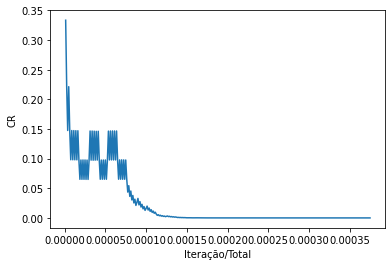

In [45]:
plt.plot(df['FRAC Its'],df['CR'])
plt.xlabel('Iteração/Total')
plt.ylabel('CR')

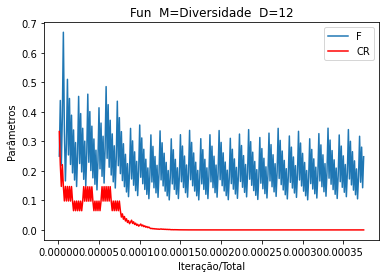

In [46]:

fig, ax = plt.subplots()
ax.plot(df['FRAC Its'],df['F'],label='F')
ax.set_xlabel('Iteração/Total')
ax.set_ylabel('Parâmetros')
ax.plot(df['FRAC Its'],df['CR'],'-r', label='CR')
nome=Fun.__name__+'  M=Diversidade'+ '  D='+str(dim)
ax.set_title(nome)
leg = ax.legend()


Text(0.5, 1.0, 'Fun_Diversidade_D=12')

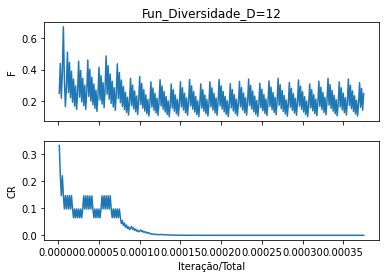

In [47]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(df['FRAC Its'],df['F'])
axarr[0].set_ylabel('F')
axarr[1].plot(df['FRAC Its'],df['CR'])
axarr[1].set_ylabel('CR')
axarr[1].set_xlabel('Iteração/Total')
nome=Fun.__name__+'_Diversidade_'+ 'D='+str(dim)
axarr[0].set_title(nome)


In [48]:
nome='_ANN_Div3x4_Fo-'+str(Fi)+'_CRo-'+str(CRi)+'_D-'+str(dim)+'_Interv-'+str(ITE)
print('DE_POP_VAR_F_CR','TOTAL=',TOTAL,'Iterações=',ITE*its,'Dim=', PAR,"Min/Max=",MIN[0],"/",MAX[0],'_',Fun.__name__)
print(nome, '\n')
#print('BEST: ',BEST)
#print('MÉDIA: ',MEAN)
print('MÉDIA: ',MEAN[-1])
print('MIN __:',MINFO)
print('MAX__: ',MAXFO)
print('STD __:',STD)
print("Tempo Médio= %.3f segundos ---" % (TIME))
print(RUNS,'Rodadas') 
print()
print('BEST: ',BEST)
# print('melhor=',BEST_AGENTS[BEST_INDEX])

DE_POP_VAR_F_CR TOTAL= 60000000 Iterações= 300 Dim= 12 Min/Max= 2 / 3 _ Fun
_ANN_Div3x4_Fo-0.5_CRo-0.5_D-12_Interv-300 

MÉDIA:  16249.239808790042
MIN __: 13191.521059233468
MAX__:  22659.573657638317
STD __: 2228.5745856471376
Tempo Médio= 50.560 segundos ---
50 Rodadas

BEST:  [ 2.65791217e+00  2.30471882e+00  2.97916414e+00  2.26981288e+00
  1.83818044e-02  0.00000000e+00  7.57723096e-01  9.53416511e-01
 -3.99999993e+01 -1.96232048e+01 -5.40271321e+01 -2.79425775e+01
  1.31915211e+04]


In [49]:
BEST=BEST[range(dim)]
print(BEST)

[ 2.65791217e+00  2.30471882e+00  2.97916414e+00  2.26981288e+00
  1.83818044e-02  0.00000000e+00  7.57723096e-01  9.53416511e-01
 -3.99999993e+01 -1.96232048e+01 -5.40271321e+01 -2.79425775e+01]


In [50]:
Busca=Numb(BEST)
print(pd.DataFrame(Busca))
df=pd.DataFrame(Busca)

            0           1           2           3
0  453.000000  393.000000  523.000000  533.000000
1  453.000000  393.000000  523.000000  533.000000
2  482.999999  393.000000  523.000000  493.000001
3  490.358701  393.000000  503.376795  493.000001
4  490.358701  474.040698  503.376795  438.972869
5  490.358701  494.997631  475.434218  438.972869
6  513.000000  508.000000  403.000000  433.000000
7  513.000000  508.000000  403.000000  433.000000


In [51]:
print(df)

            0           1           2           3
0  453.000000  393.000000  523.000000  533.000000
1  453.000000  393.000000  523.000000  533.000000
2  482.999999  393.000000  523.000000  493.000001
3  490.358701  393.000000  503.376795  493.000001
4  490.358701  474.040698  503.376795  438.972869
5  490.358701  494.997631  475.434218  438.972869
6  513.000000  508.000000  403.000000  433.000000
7  513.000000  508.000000  403.000000  433.000000


Text(0, 0.5, 'Temperature (K)')

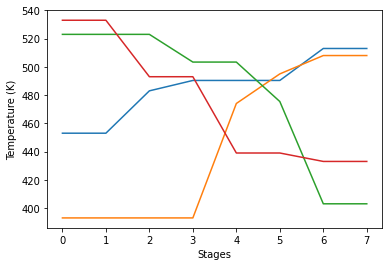

In [52]:
Streams=4
Change=range(Streams+4) # Streams+4 so para ficar com um visual melhor
for k in range(Streams):
  plt.plot(Change,df.iloc[:,k])
plt.xlabel('Stages')
plt.ylabel('Temperature (K)')